In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.5


## GPU

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
tf_device='/gpu:2'

## Bibliotecas

In [4]:
# Imports 

# Imports para manipulação e visualização de dados
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os 
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split

# Imports para cálculo de métricas e utilitários
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

# Imports para Deep Learning
#import plaidml
#import plaidml.keras
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback

# Redes Neurais
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "SINFO" --iversions

Author: SINFO

matplotlib: 3.3.4
sklearn   : 0.24.1
numpy     : 1.19.2
PIL       : 8.1.2
keras     : 2.4.3
pandas    : 1.2.3
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
tensorflow: 2.4.1



## Parâmetros

In [6]:
# Dados de entrada
#PATH_IMAGES = 'dataset/Monkeypox_2_classes/Original_Images/Original_Images/'
PATH_IMAGES = 'dataset/Monkeypox_4_classes/dataset/'

# Parâmetros do treinamento
BATCH_SIZE = 8
SEED = 42

# K-fold
N_SPLIT = 4

In [7]:
# Parâmetros treinamento
epocas_treinamento = 20
base_learning_rate = 0.0001

epocas_ajuste_fino = 10
total_epocas = epocas_treinamento + epocas_ajuste_fino

# Dataset

In [8]:
#CATEGORIAS = ['Monkey Pox', 'Others']
CATEGORIAS = ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
NUM_CATEGORIAS = len(CATEGORIAS)
NUM_CATEGORIAS

4

In [9]:
for category in CATEGORIAS:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(PATH_IMAGES, category)))))

Chickenpox 108 images
Measles 91 images
Monkeypox 279 images
Normal 293 images


In [10]:
dataset = []
for category in CATEGORIAS:
    for file in os.listdir(os.path.join(PATH_IMAGES, category)):
        dataset.append(['{}/{}'.format(category, file), category])
dataset = pd.DataFrame(dataset, columns=['arquivo', 'categoria'])
dataset.shape

(771, 2)

In [11]:
dataset

,arquivo,categoria
0,Chickenpox/chickenpox49.png,Chickenpox
1,Chickenpox/chickenpox13.png,Chickenpox
2,Chickenpox/chickenpox41.png,Chickenpox
3,Chickenpox/chickenpox61.png,Chickenpox
4,Chickenpox/chickenpox39.png,Chickenpox
...,...,...
766,Normal/normal89.png,Normal
767,Normal/normal47.png,Normal
768,Normal/normal37.png,Normal
769,Normal/normal55.png,Normal


In [12]:
# Definindo X e Y
dataset_x = dataset.arquivo
dataset_y = dataset.categoria

# Leitura dos dados

In [13]:
#Initializing Data Generators
datagen = ImageDataGenerator()

# train_datagen = ImageDataGenerator(rescale = 1.0/255,
#                                     zoom_range = 0.2, 
#                                     horizontal_flip = True, 
#                                     vertical_flip = True,
#                                     rotation_range = 90,
#                                     brightness_range = (-0.1, 0.1))

In [14]:
# Carrega os dados de treino, validação e testes
def leitura_dados(img_size):
    train_dataset = datagen.flow_from_dataframe(dataframe = train_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      seed = SEED,
                                                      shuffle = True)

    val_dataset = datagen.flow_from_dataframe(dataframe = val_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      shuffle = False)

    test_dataset = datagen.flow_from_dataframe(dataframe = test_df, 
                                                      directory = PATH_IMAGES,
                                                      x_col = "arquivo", 
                                                      y_col = "categoria",
                                                      class_mode = "categorical",
                                                      target_size = img_size, 
                                                      batch_size = BATCH_SIZE,
                                                      shuffle = False)
    
    return train_dataset, val_dataset, test_dataset

# Métricas

In [15]:
# Cria data frame de resultados
# colunas_dataframe = ['model', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'kappa', 'precision', 'fscore', 'specificity', 'sensitivity', 'auc']
# resultados = pd.DataFrame(columns = colunas_dataframe)

def calcula_metricas_binarias(y_true, y_pred):
    
    global resultados
    
    # Cutoff
    y_true = (y_true > 0.5).flatten()
    y_pred = (y_pred > 0.5).flatten()

    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
    kappa = (2 * (tp * tn - fn * fp) / (tp * fn + tp * fp + 2 * tp * tn + fn^2 + fn * fn + fp^2 + fp * tn))
    precision = float(tp)/float(tp + fp)
    fscore = float(2*tp)/float(2*tp + fp + fn)
    specificity = (1.0 * tn) / (tn + fp)
    sensitivity = (1.0 * tp) / (tp + fn)
    auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
    
    resultados = resultados.append({'model': models[rede].name, 
                                    'tp': tp, 
                                    'fp': fp,
                                    'tn': tn,
                                    'fn': fn,
                                    'accuracy': accuracy,
                                    'kappa': kappa,
                                    'precision': precision,
                                    'fscore': fscore,
                                    'specificity': specificity,
                                    'sensitivity': sensitivity,
                                    'auc': auc}, ignore_index=True)

In [16]:
# Cria data frame de resultados
colunas_dataframe = ['model', 'kappa', 'accuracy', 'recall', 'precision', 'f1', 'specificity', 'roc']
resultados = pd.DataFrame(columns = colunas_dataframe)

def metrics_multi_class(y_true, y_pred):
    '''
        fonte: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
    '''
    
    global resultados
    
    cnf_matrix = confusion_matrix(y_true,y_pred)

    fp = (cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)).astype(float)
    fn = (cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)).astype(float)
    tp = (np.diag(cnf_matrix)).astype(float)
    tn = (cnf_matrix.sum() - (fp + fn + tp)).astype(float)
    
    weights = np.sum(cnf_matrix, axis=1)
    specificity_array = (tn / (tn + fp))
    specificity = np.sum(specificity_array * weights) / np.sum(weights)
    
    kappa = cohen_kappa_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted') # sensibility
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # ROC
    lb = LabelBinarizer()
    lb.fit(y_true)
    true = lb.transform(y_true)
    pred = lb.transform(y_pred)
    roc = roc_auc_score(true, pred)
    
    metricas = {'model': models[rede].name, 
                'kappa': kappa,
                'accuracy': accuracy,
                'recall': recall,
                'precision': precision,
                'f1': f1,
                'specificity':specificity,
                'roc': roc}
    
    print(metricas)
    
    resultados = resultados.append(metricas, ignore_index=True)

In [17]:
import itertools
list_confusion_matrix = []

# Função para a Matriz de Confusão
def plot_confusion_matrix(normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues):
    
    classes = ['Catapora', 'Sarampo', 'Varíola dos Macacos', 'Normal']
    cm = confusion_matrix(y_true, y_pred)
    list_confusion_matrix.append(cm)
    
    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

# Modelo

In [18]:
# leitura dos pesos pré-treinados da ImageNet
# Não inclui as camadas de classificação no topo, ideal para extração de features
models = [
    VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False),
    DenseNet201(weights = "imagenet", input_shape = (224, 224, 3), include_top = False),
    InceptionV3(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False),
    NASNetLarge(weights='imagenet', input_shape=(331, 331, 3), include_top=False),
    ResNet152V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
]

# Reescala dos valores dos pixels do modelo
processamento_input = [
    keras.applications.vgg16.preprocess_input,
    keras.applications.densenet.preprocess_input,
    keras.applications.inception_v3.preprocess_input,
    keras.applications.xception.preprocess_input,
    keras.applications.inception_resnet_v2.preprocess_input,
    keras.applications.nasnet.preprocess_input,
    keras.applications.resnet_v2.preprocess_input
]

In [19]:
# Construir um modelo a partir de redes neurais pré-treinadas
def modelo_base(rede):
    
    base_model = models[rede]
    img_size = (base_model.input.shape[1], base_model.input.shape[2])
    
    # Processa as entradas do modelo
    preprocess_input = processamento_input[rede]
    
    return base_model, img_size, preprocess_input

In [20]:
# Usando aumento de dados aleatórios somente no fit (treinamento)
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        # keras.layers.experimental.preprocessing.RandomRotation(0.1), # retirar por conta dos cantos pretos
        keras.layers.experimental.preprocessing.RandomZoom(0.1),
        keras.layers.experimental.preprocessing.RandomContrast(0.2)
    ]
)

In [21]:
# Construir modelo
def build_model():
    
    # Freeze the base_model
    # Congela a base convolucional antes de compilar e treinar o modelo
    # Evita que os pesos em uma determinada camada sejam atualizados durante o treinamento
    base_model.trainable = False
    
    # Arquitetura do modelo básico
    # base_model.summary()

    # Adiciona o cabeçalho de classificação
    # Converter as features do shape `base_model.output_shape[1:] para vectores
    global_average_layer = keras.layers.GlobalAveragePooling2D()

    # Aplica uma camada densa para converter essas features em uma única previsão por imagem
    # Os números > 0.5 preveem a classe 1, os números <= 0.5 preveem a classe 0
    prediction_layer = keras.layers.Dense(4, activation="softmax", name='predictions') # Função de ativação sigmoid adicionada

    # Modelo encadeando as camadas de aumento de dados, reescalonamento, base_model e extrator de features
    img_shape = img_size + (3,)
    inputs = keras.Input(shape = img_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = keras.Model(inputs, outputs)  
    
    return model

In [22]:
# Compile o modelo antes de treiná-lo
def compile_model(learning_rate):
    
    # Compilar modelo
    # Não especifiquei o batch_size, pois os dados já estão em conjuntos (batchs)
    model.compile(optimizer = Adam(lr = learning_rate), loss = keras.losses.CategoricalCrossentropy(), metrics = ['categorical_accuracy'])
    
    # model.summary()

In [23]:
# Definimos um checkpoint para verificar regularmente se a perda em validação diminuiu
# Se a performance melhorar em validação salvamos o modelo
# Podemos ainda optar por salvar o modelo a cada número de épocas
# callbacks
# Redução gradual da taxa de aprendizado (Reduce on Plateau)
def get_callbacks():
    return [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1),
            ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.0000001, verbose = 1),
            ModelCheckpoint('modelo/{}.h5'.format(models[rede].name), 
                         verbose = 1, 
                         save_best_only = True, 
                         save_weights_only = True)]

In [24]:
# Treinamento do modelo
def treinamento_model(qnt_epocas, epoca_inicial):
    
    history = model.fit(train_dataset,
                        epochs = qnt_epocas,
                        initial_epoch = epoca_inicial,
                        validation_data = val_dataset,
                        verbose=1,
                        callbacks = get_callbacks())
    
    return history

In [25]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
def aprendizado_treinamento():
    
    metricas_graficos = ["loss", "categorical_accuracy"]
    nomes = ["Loss", "Acurácia"]
          
    fig, ax = plt.subplots(len(metricas_graficos), 1, figsize=(10, len(metricas_graficos)*6))
    ax = ax.ravel()
    dados_x = np.arange(1, epocas_treinamento+1, 1)

    for i, met in enumerate(metricas_graficos):        
        ax[i].plot(dados_x, history.history[met], label='Treinamento')
        ax[i].plot(dados_x, history.history["val_" + met], label='Validação')
        ax[i].set_title("Curvas de aprendizado da %s no modelo %s" %(nomes[i], models[rede].name))
        ax[i].set_xlabel("Épocas")
        ax[i].set_ylabel(nomes[i])
        
        if (i != 0): # loss function
            ax[i].legend(loc='lower right')
        else:
            ax[i].legend(loc='upper right')
    
    return metricas_graficos

In [26]:
# LIMIAR PARA AJUSTE FINO (OPCIONAL)
# Definir as camadas inferiores como não treináveis
def limiar_ajuste_fino():
    
    # Exibe a quantidade de camadas do modelo base
    # print("Número de camadas no modelo base: ", len(base_model.layers))

    # Ajuste fino desta camada em diante
    fine_tune_at = 100

    # Congele todas as camadas antes da camada 'fine_tune_at'
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

In [27]:
# Ajuste fino
def ajuste_fino():
    
    # Foi treinado apenas algumas camadas do modelo. 
    # Os pesos da rede pré-treinada não foram atualizados durante o treinamento.
    # Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores 
    # do modelo pré-treinado junto com o treinamento do classificador adicionado (camada de classificação adicionada)
    # Descongelar as camadas superiores do modelo (descongelar base_model)
    base_model.trainable = True
    
    # Limiar ajuste fino (OPCIONAL)
    limiar_ajuste_fino()
    
    # É necessário recompilar o modelo (para que essas alterações tenham efeito)
    # É importante usar uma taxa de aprendizado mais baixa neste estágio, 
    # pois está usando um modelo muito maior e deseja readaptar os pesos pré-treinados
    compile_model(base_learning_rate/10)
    
    # Retomar o treinamento melhorará sua precisão em alguns pontos percentuais
    # history.epoch[-1] é a última época do ultimo treinamento
    history_fine = treinamento_model(total_epocas, history.epoch[-1]+1)
    
    return history_fine

In [28]:
# Curvas de aprendizado da precisão / perda de treinamento e validação ao ajustar as últimas camadas do modelo
def aprendizado_ajuste_fino():
    
    fig, ax = plt.subplots(len(metricas_graficos), 1, figsize=(12, len(metricas_graficos)*6))
    ax = ax.ravel()
    dados_x = np.arange(1, len(history.history['loss']) + len(history_fine.history['loss'])+1, 1)
    
    nomes = ["Loss", "Acurácia"]

    for i, met in enumerate(metricas_graficos):
        dados_treino = history.history[met] + history_fine.history[met]
        dados_validacao = history.history["val_" + met] + history_fine.history["val_" + met]
        
        ax[i].plot(dados_x, dados_treino, label='Treinamento')
        ax[i].plot(dados_x, dados_validacao, label='Validação ')
        ax[i].plot([epocas_treinamento, epocas_treinamento], plt.ylim(), label='Início do Ajuste Fino')
        ax[i].set_title("Curvas de aprendizado da %s no modelo %s" %(nomes[i], models[rede].name))
        ax[i].set_xlabel("Épocas")
        ax[i].set_ylabel(nomes[i])
        
        if (i != 0): # loss function
            ax[i].legend(loc='lower right')
        else:
            ax[i].legend(loc='upper right')

# Treinamento K-fold


Iteração 1 de 4

Executando modelo inception_resnet_v2
Found 577 validated image filenames belonging to 4 classes.
Found 77 validated image filenames belonging to 4 classes.
Found 116 validated image filenames belonging to 4 classes.
Epoch 1/20
73/73 [==============================] - 95s 854ms/step - loss: 1.3248 - categorical_accuracy: 0.3642 - val_loss: 1.0234 - val_categorical_accuracy: 0.6494

Epoch 00001: val_loss improved from inf to 1.02339, saving model to modelo/inception_resnet_v2.h5
Epoch 2/20
73/73 [==============================] - 4s 54ms/step - loss: 1.0827 - categorical_accuracy: 0.5992 - val_loss: 0.8587 - val_categorical_accuracy: 0.7013

Epoch 00002: val_loss improved from 1.02339 to 0.85870, saving model to modelo/inception_resnet_v2.h5
Epoch 3/20
73/73 [==============================] - 4s 53ms/step - loss: 0.9333 - categorical_accuracy: 0.6448 - val_loss: 0.7616 - val_categorical_accuracy: 0.7403

Epoch 00003: val_loss improved from 0.85870 to 0.76155, saving mo

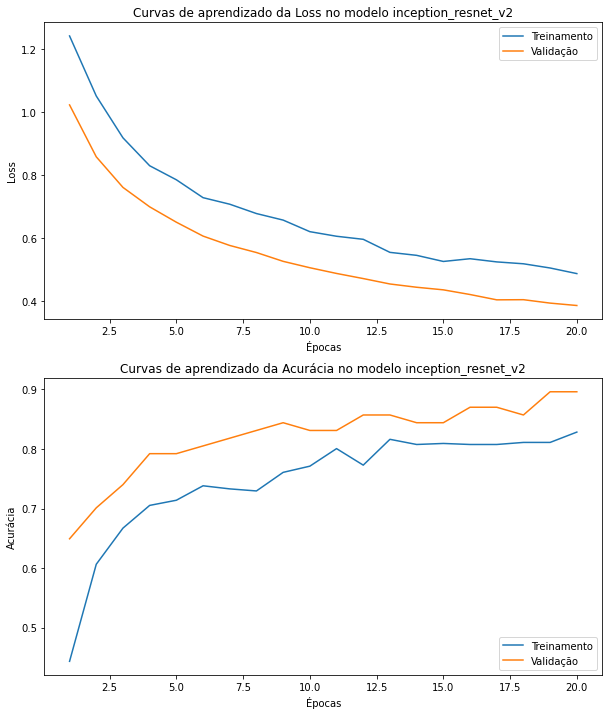

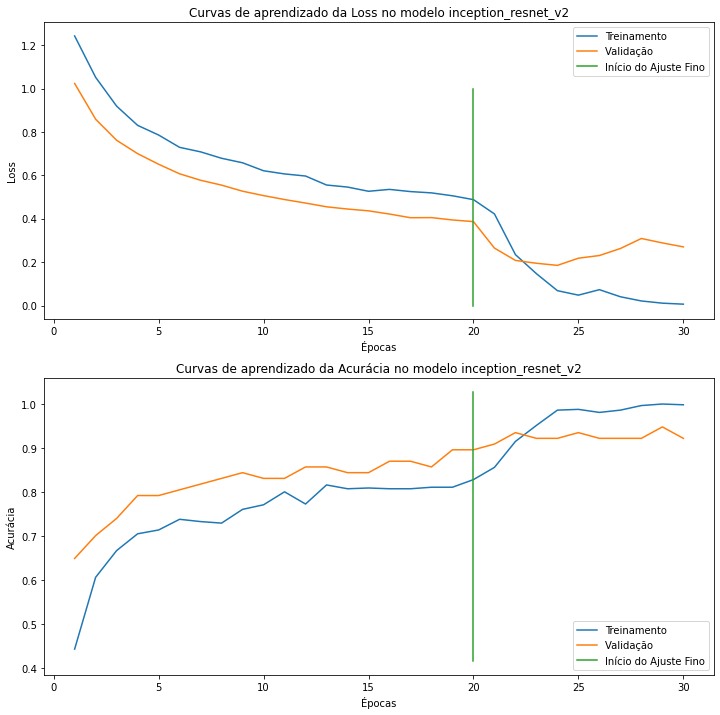

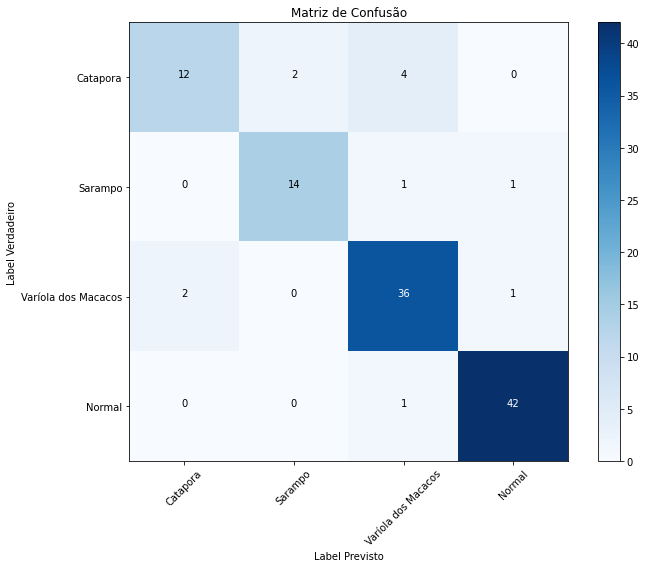

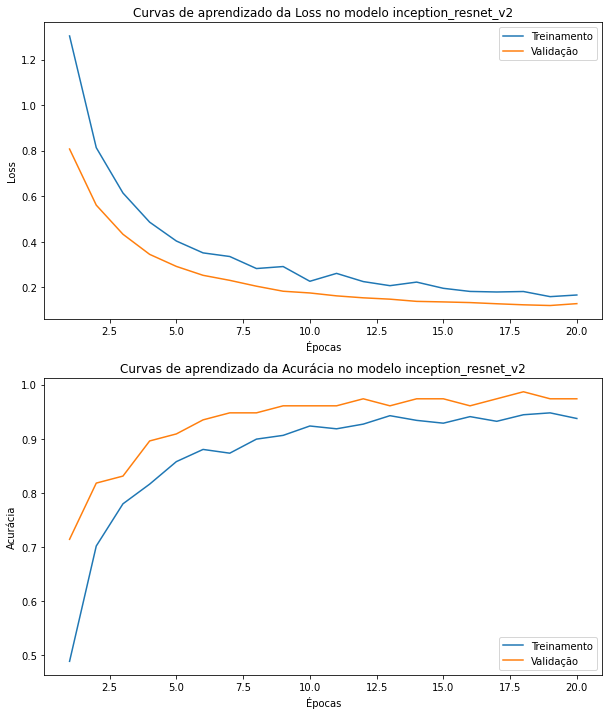

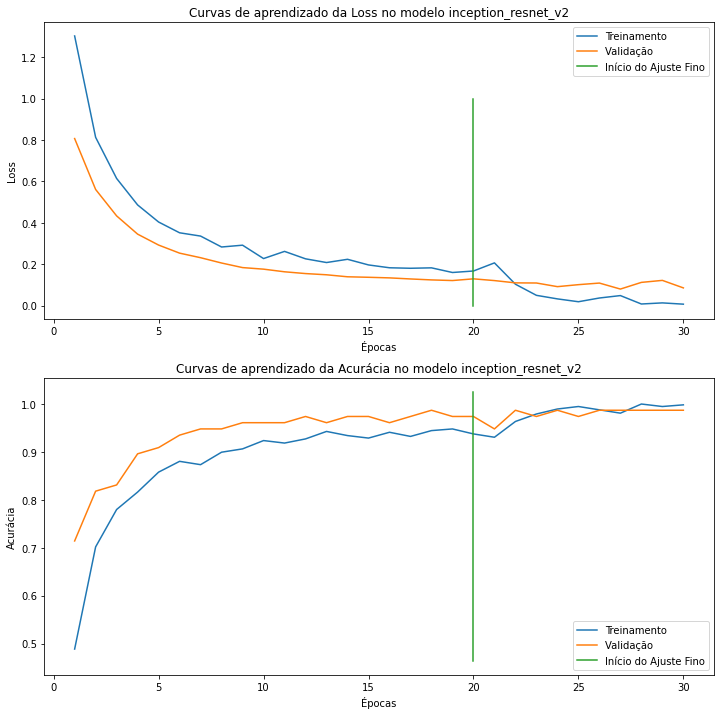

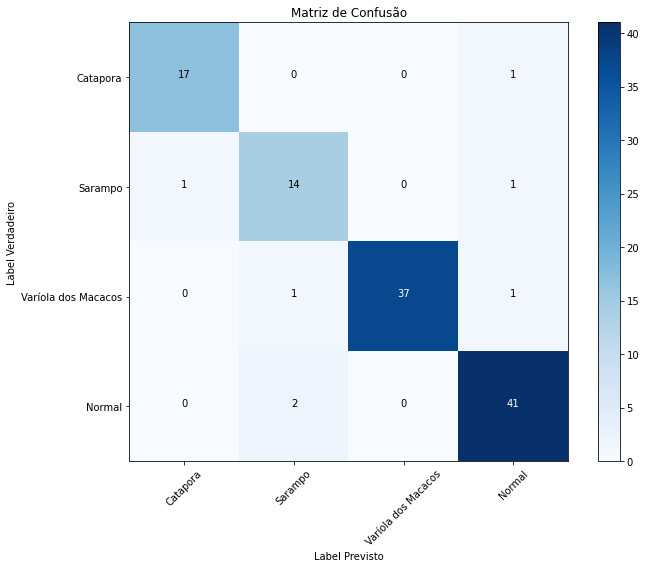

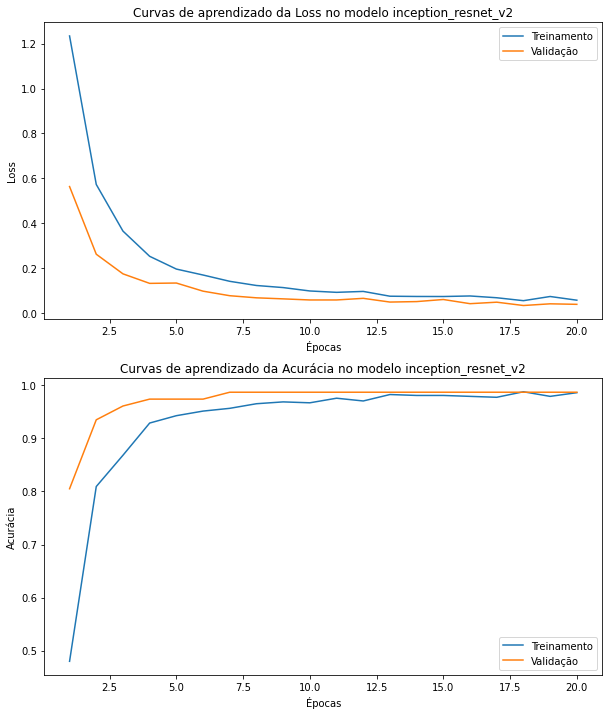

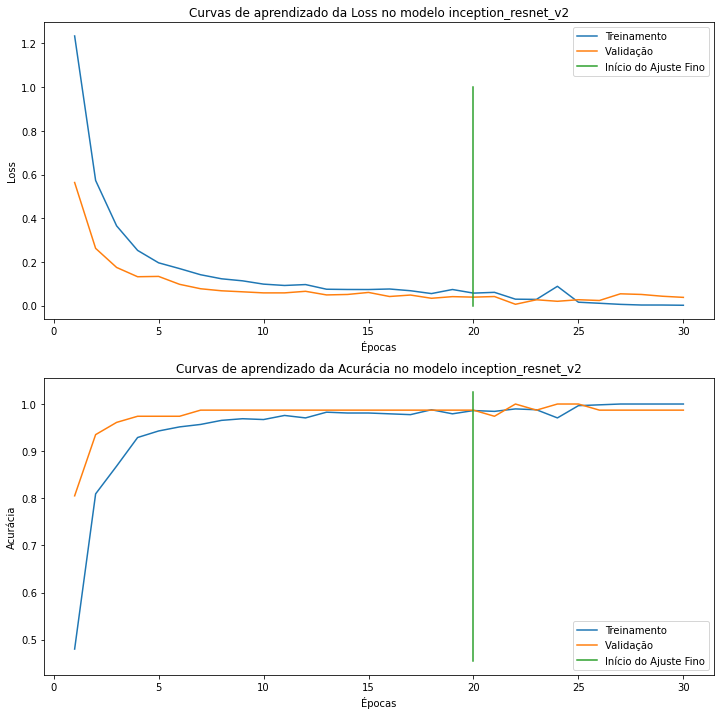

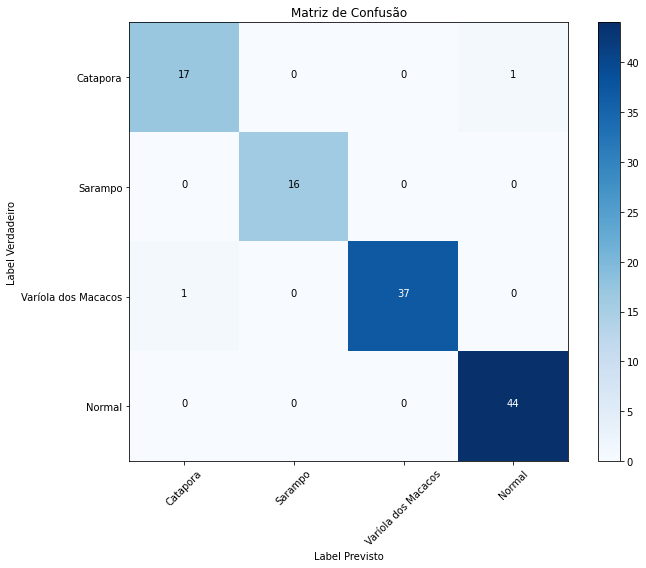

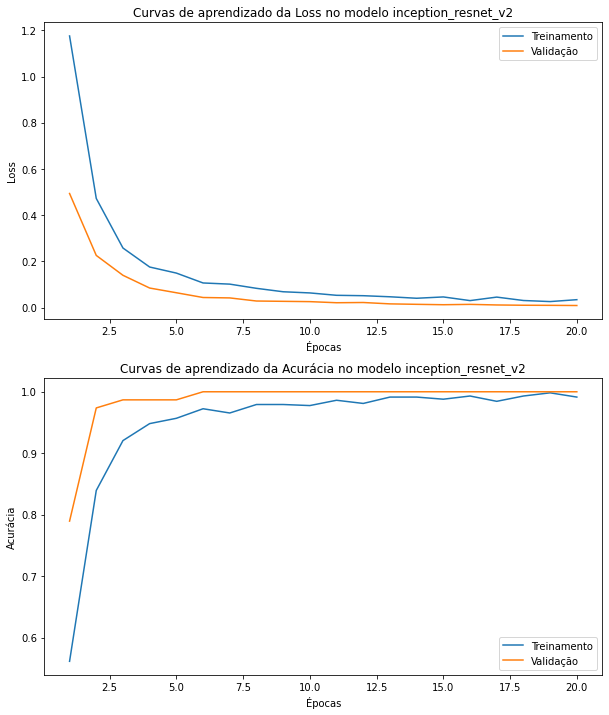

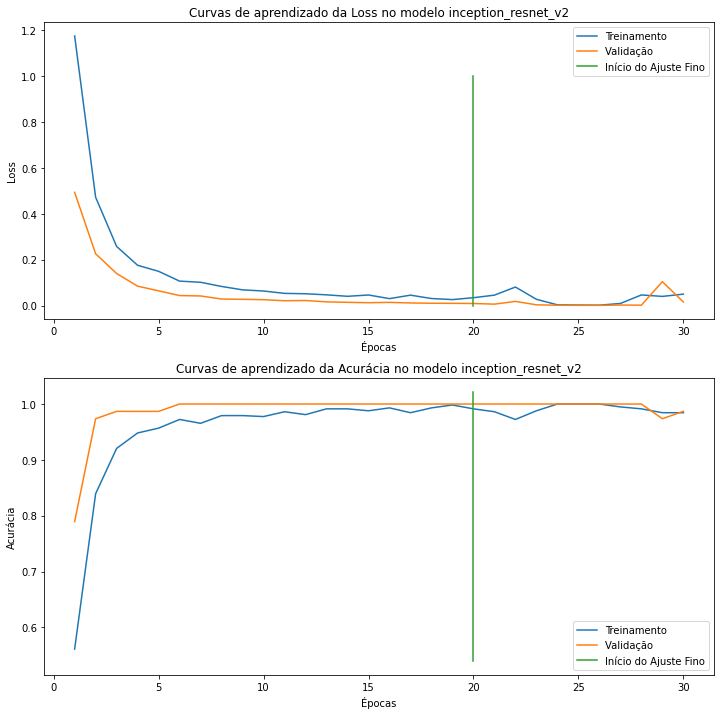

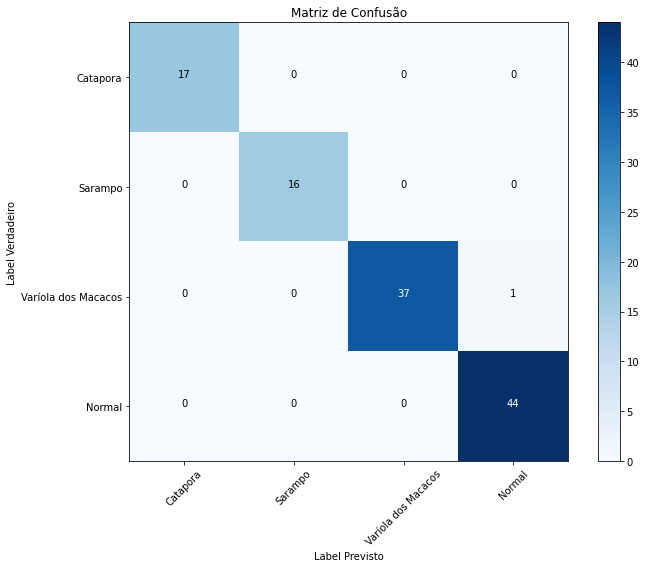

In [29]:
# k-fold
kfold = StratifiedKFold(n_splits = N_SPLIT, shuffle = True, random_state = SEED)

# Contador de iterações do k-fold
iteracao = 1

# K-fold treino e teste de cada divisão
for train_idx, test_idx in list(kfold.split(dataset_x, dataset_y)):
    
    print("\n======================================================")
    print("Iteração {} de {}".format(iteracao, N_SPLIT))
    print("======================================================")
    
    train_df = dataset.iloc[train_idx]
    test_temp = dataset.iloc[test_idx]
    
    # dividir o teste em validação e teste
    val_df, test_df = train_test_split(test_temp, test_size = 0.60, random_state = SEED) # 10% validação e 15% teste
    
    #for rede in range(len(models)): # Todos os modelos
    rede = 4
        
    print('\nExecutando modelo {}'.format(models[rede].name))

    # Modelo base
    base_model, img_size, preprocess_input = modelo_base(rede)

    # Leitura dos dados
    train_dataset, val_dataset, test_dataset = leitura_dados(img_size)

    # Construir modelo
    model = build_model()

    # Compilar Modelo
    compile_model(base_learning_rate)

    # Treinamento do modelo
    history = treinamento_model(epocas_treinamento, 0)

    # Curvas de aprendizado da precisão / perda de treinamento e validação ao usar o modelo
    metricas_graficos = aprendizado_treinamento()

    # Ajuste fino
    history_fine = ajuste_fino()

    # Curvas de aprendizado da precisão / perda de treinamento e validação ao ajustar as últimas camadas do modelo
    aprendizado_ajuste_fino()

    # Carrega o melhor modelo
    model.load_weights('modelo/{}.h5'.format(models[rede].name))

    # Obtemos os rótulos verdadeiros
    y_true = np.array(test_dataset.classes)

    # Obtemos os rótulos previstos
    previsoes = model.predict(test_dataset, verbose = 1)
    y_pred = previsoes.argmax(axis=1)

    # Calcula métricas Multiclasse
    metrics_multi_class(y_true, y_pred)

    # Plota matriz de confusão
    plot_confusion_matrix()

    # Gera o relatório de classificação
    # report = classification_report(y_true, y_pred, target_names = CATEGORIAS)
    # print(report)
    
    # Limpa a sessão
    keras.backend.clear_session()
    
    iteracao = iteracao + 1

In [30]:
list_confusion_matrix

[array([[12,  2,  4,  0],
        [ 0, 14,  1,  1],
        [ 2,  0, 36,  1],
        [ 0,  0,  1, 42]]),
 array([[17,  0,  0,  1],
        [ 1, 14,  0,  1],
        [ 0,  1, 37,  1],
        [ 0,  2,  0, 41]]),
 array([[17,  0,  0,  1],
        [ 0, 16,  0,  0],
        [ 1,  0, 37,  0],
        [ 0,  0,  0, 44]]),
 array([[17,  0,  0,  0],
        [ 0, 16,  0,  0],
        [ 0,  0, 37,  1],
        [ 0,  0,  0, 44]])]

In [62]:
matriz_confusao_media = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        elemento = np.mean([list_confusion_matrix[0][i][j], 
                            list_confusion_matrix[1][i][j], 
                            list_confusion_matrix[2][i][j], 
                            list_confusion_matrix[3][i][j]])
        # print(elemento)
        matriz_confusao_media[i][j] = elemento

In [63]:
matriz_confusao_media

array([[15.75,  0.5 ,  1.  ,  0.5 ],
       [ 0.25, 15.  ,  0.25,  0.5 ],
       [ 0.75,  0.25, 36.75,  0.75],
       [ 0.  ,  0.5 ,  0.25, 42.75]])

In [64]:
matriz_confusao_media = np.round(matriz_confusao_media, 0).astype(int)
matriz_confusao_media

array([[16,  0,  1,  0],
       [ 0, 15,  0,  0],
       [ 1,  0, 37,  1],
       [ 0,  0,  0, 43]])

In [68]:
import itertools

# Função para a Matriz de Confusão
def plot_confusion_matrix2(normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues, cm = confusion_matrix(y_true, y_pred)):
    
    classes = ['Catapora', 'Sarampo', 'Varíola dos Macacos', 'Normal']
    
    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

Matriz de Confusão Sem Normalização
[[16  0  1  0]
 [ 0 15  0  0]
 [ 1  0 37  1]
 [ 0  0  0 43]]


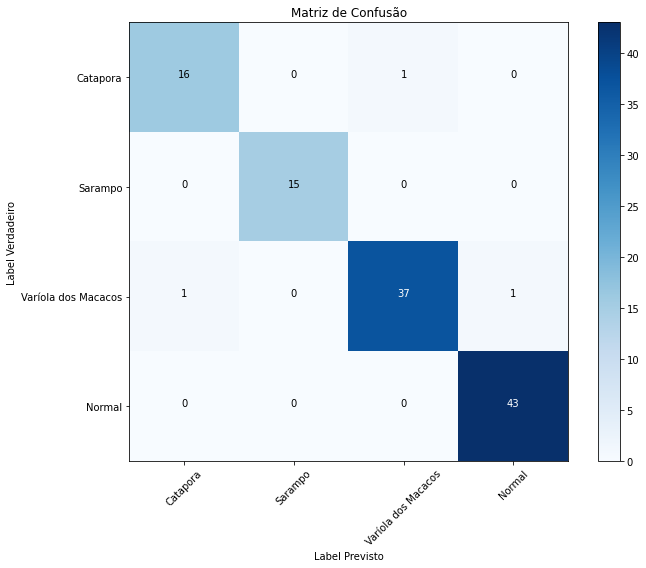

In [69]:
plot_confusion_matrix2(cm=matriz_confusao_media)